# Required libraries

In [ ]:
!pip install numpy
!pip install pandas
!pip install matplotlib
!pip install seaborn
!pip install scikit-learn

# Imports

In [7]:
import pandas as pd
import numpy as np
import seaborn as sns
import time

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from tqdm import tqdm
from sklearn.metrics import classification_report,confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

# Get Data

In [8]:
obesity_data = pd.read_csv('obesity_data.csv')
obesity_data.describe()

,Age,Height,Weight,BMI,PhysicalActivityLevel
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,49.857000,170.052417,71.205769,24.888317,2.534000
std,18.114267,10.309971,15.509849,6.193912,1.116284
min,18.000000,136.115719,26.065730,8.470572,1.000000
25%,35.000000,163.514205,61.129629,20.918068,2.000000
50%,50.000000,169.801665,71.929072,24.698647,3.000000
75%,66.000000,177.353596,81.133746,28.732132,4.000000
max,79.000000,201.419670,118.907366,50.791898,4.000000


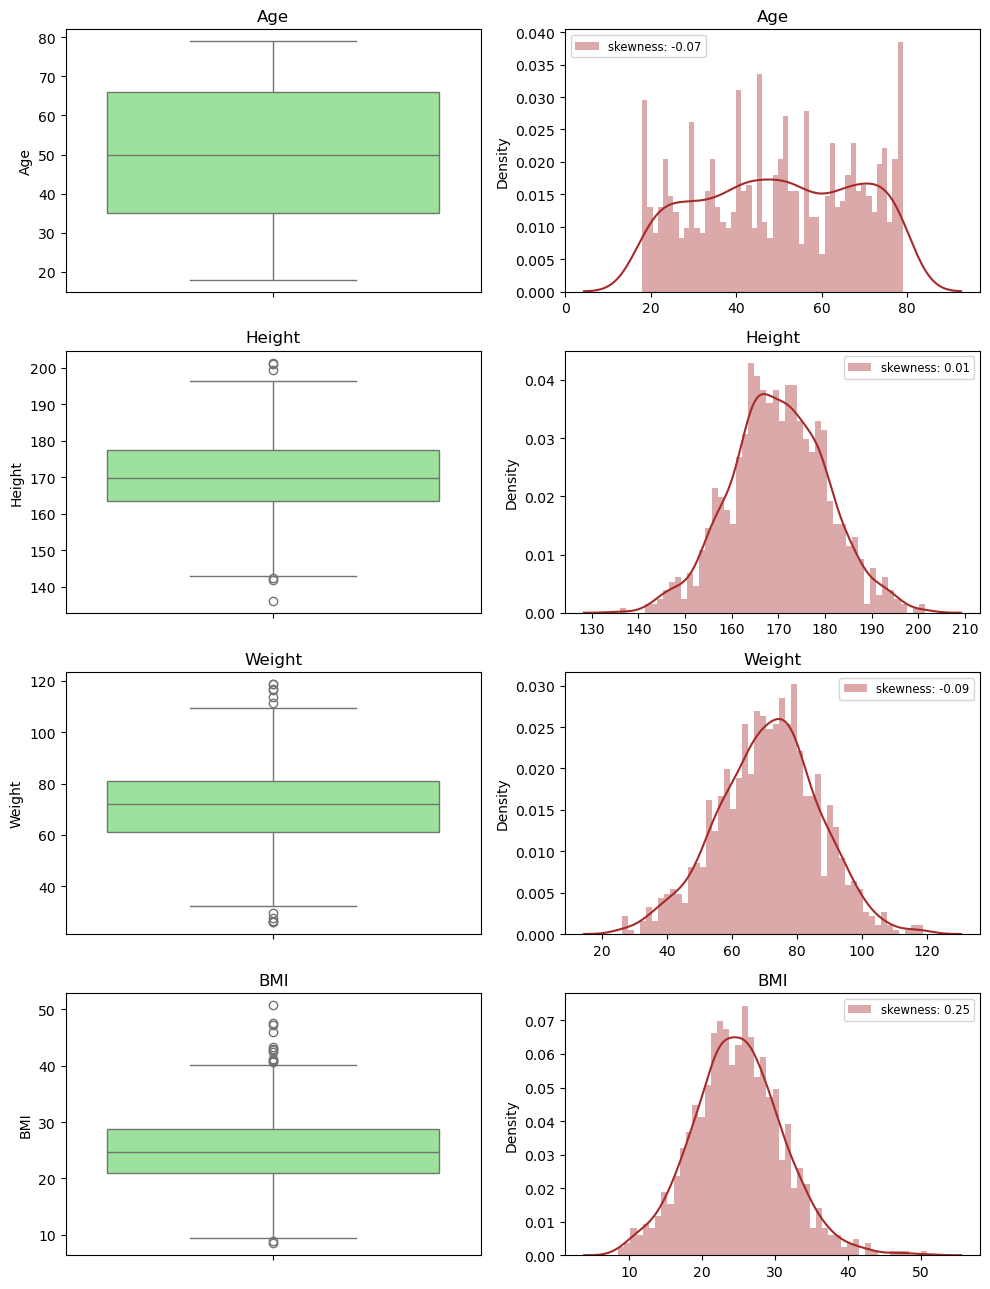

In [9]:
num_cols = obesity_data.select_dtypes(include=np.number).columns

fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(10, 13))
axes = axes.flatten()

for i, col in enumerate(num_cols[:-1]):
    ax1 = axes[i * 2]
    ax2 = axes[i * 2 + 1]

    sns.boxplot(data=obesity_data[col], ax=ax1, color="lightgreen")
    ax1.set_title(col)

    sns.distplot(obesity_data[col], ax=ax2, color="brown", bins=50, label=f"skewness: {obesity_data[col].skew().round(2)}")
    ax2.set_title(col)
    ax2.set_xlabel("")
    ax2.legend(fontsize="small")

plt.tight_layout()
plt.show()

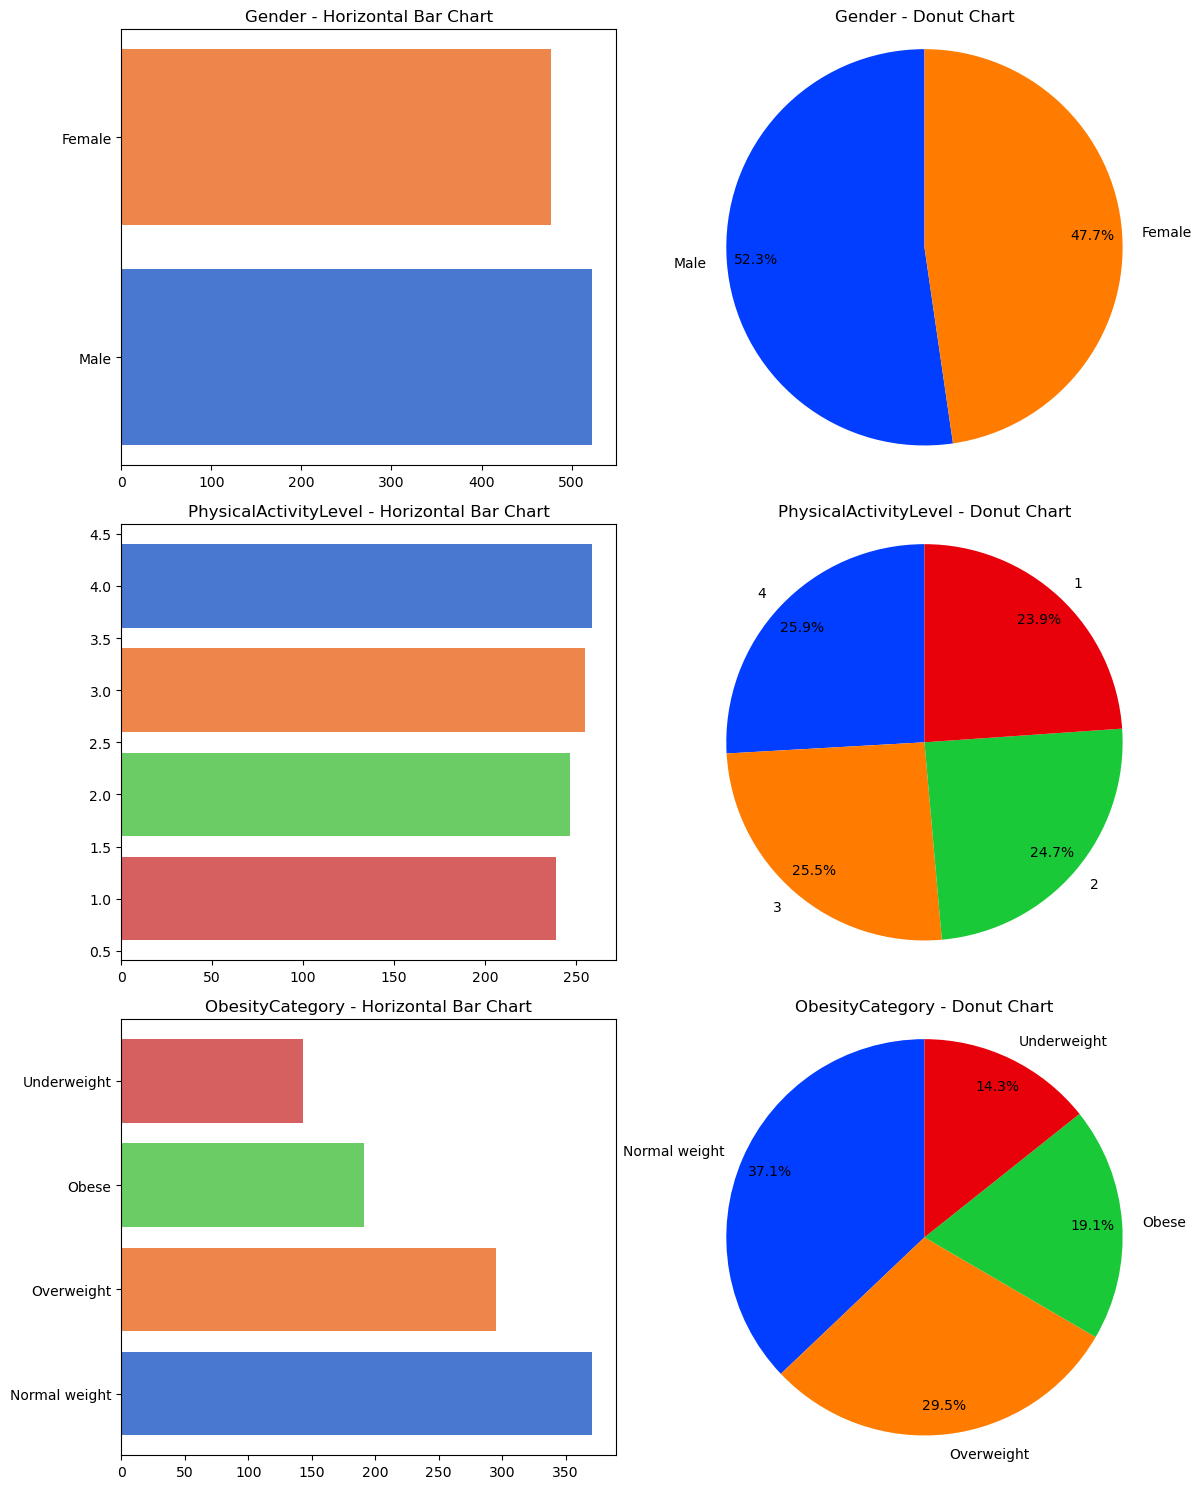

In [10]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12, 15))
axes = axes.flatten()

categorical_cols = ["Gender", "PhysicalActivityLevel", "ObesityCategory"]

for i, col in enumerate(categorical_cols):
    ax1, ax2 = axes[i * 2], axes[i * 2 + 1]

    # Horizontal bar chart
    value_counts = obesity_data[col].value_counts()
    ax1.barh(value_counts.index, value_counts.values, color=sns.color_palette("muted"))
    ax1.set_title(f"{col} - Horizontal Bar Chart")

    # Donut chart
    sizes = obesity_data[col].value_counts().values
    labels = obesity_data[col].value_counts().index
    colors = sns.color_palette("bright")[:len(sizes)]
    ax2.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90, pctdistance=0.85)
    ax2.axis('equal')  
    ax2.set_title(f"{col} - Donut Chart")

plt.tight_layout()
plt.show()

In [11]:
obesity_data

,Age,Gender,Height,Weight,BMI,PhysicalActivityLevel,ObesityCategory
0,56,Male,173.575262,71.982051,23.891783,4,Normal weight
1,69,Male,164.127306,89.959256,33.395209,2,Obese
2,46,Female,168.072202,72.930629,25.817737,4,Overweight
3,32,Male,168.459633,84.886912,29.912247,3,Overweight
4,60,Male,183.568568,69.038945,20.487903,3,Normal weight
...,...,...,...,...,...,...,...
995,18,Male,155.588674,64.103182,26.480345,4,Overweight
996,35,Female,165.076490,97.639771,35.830783,1,Obese
997,49,Female,156.570956,78.804284,32.146036,1,Obese
998,64,Male,164.192222,57.978115,21.505965,4,Normal weight


# Data Preprocessing

In [12]:
print('Number of rows with missing data: ', obesity_data.shape[0] - obesity_data.dropna().shape[0])

Number of rows with missing data:  0


In [13]:
def get_int_category(x):
    if x == 'Underweight':
        return 0
    elif x == 'Normal weight':
        return 1
    elif x == 'Overweight':
        return 2
    else:
        return 3

In [14]:
obesity_data['ObesityCategoryInt'] = obesity_data['ObesityCategory'].apply(lambda x: get_int_category(x))

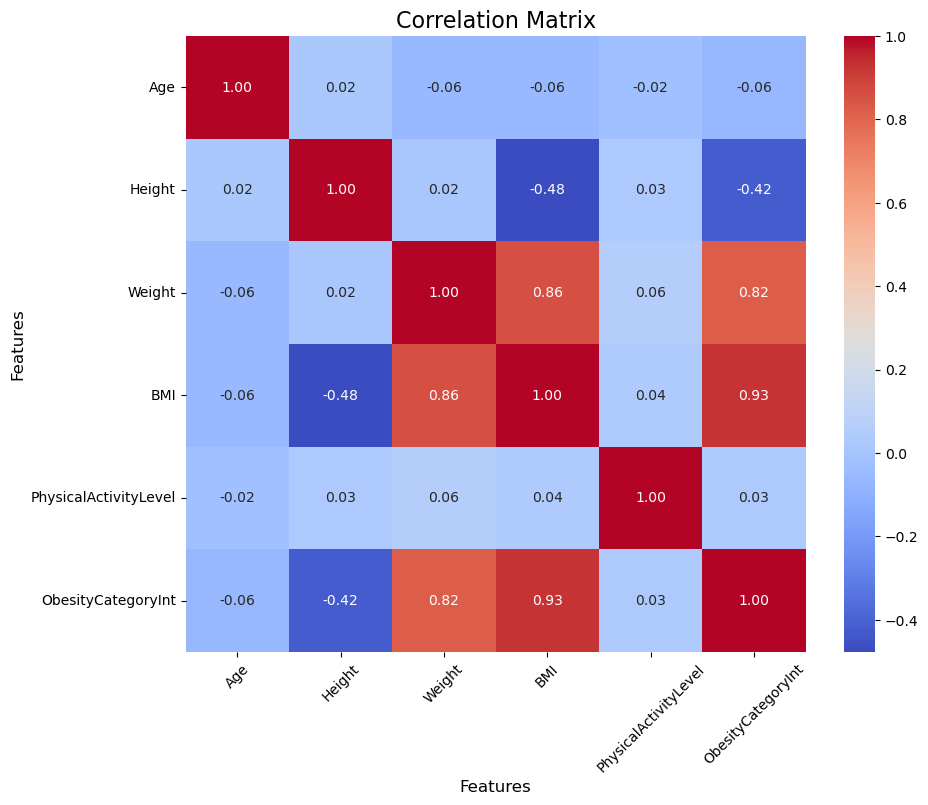

In [15]:
num_cols = obesity_data.select_dtypes(include=np.number).columns
corr_matrix = obesity_data[num_cols].corr()

fig, ax = plt.subplots(figsize=(10, 8))

sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", ax=ax)

ax.set_title("Correlation Matrix", fontsize=16)
ax.set_xlabel("Features", fontsize=12)
ax.set_ylabel("Features", fontsize=12)
ax.tick_params(axis='both', which='major', labelsize=10)
plt.xticks(rotation=45)

plt.show()

<Axes: xlabel='BMI', ylabel='ObesityCategoryInt'>

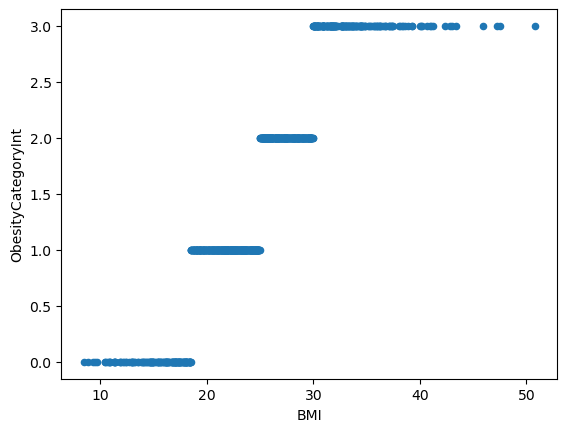

In [16]:
obesity_data.plot.scatter(x='BMI', y='ObesityCategoryInt')

# Attribute Selection

In [17]:
X_full = obesity_data.copy(deep=True)
y_full = X_full.pop('ObesityCategoryInt')
X_full['Gender'] = X_full['Gender'].apply(lambda g: 1 if g == 'Male' else 0)
X_full.drop(columns=['ObesityCategory'], inplace=True)

feature_selector = SequentialFeatureSelector(DecisionTreeClassifier(), direction='forward', tol=.001)
feature_selector.fit(X_full, y_full)
feature_selector.feature_names_in_[feature_selector.get_support()]

array(['BMI'], dtype=object)

In [18]:
feature_selector = SequentialFeatureSelector(DecisionTreeClassifier(), direction='backward', tol=-.001)
feature_selector.fit(X_full, y_full)
feature_selector.feature_names_in_[feature_selector.get_support()]

array(['BMI'], dtype=object)

# Model

<h5>Separating 20% of test data for later use. This is done not to overfit the model for test data</h5>

In [19]:
X_train, X_test, y_train, y_test = train_test_split(obesity_data[['BMI']], 
                                                    obesity_data['ObesityCategoryInt'], 
                                                    test_size=0.2, 
                                                    stratify=obesity_data['ObesityCategoryInt'], 
                                                    random_state=121)

In [20]:
# Feature scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [21]:
param_grid = {
    'max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10]
}

In [25]:
model_accuracies = []
k_folds = 10
stratified_kfold = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=42)

In [26]:
cross_validation = GridSearchCV(DecisionTreeClassifier(random_state=42, splitter='best'), param_grid, cv=stratified_kfold)
cross_validation.fit(X_train, y_train)
print(cross_validation.cv_results_)
accuracy_score = cross_validation.best_estimator_.score(X_test, y_test)
model_accuracies.append({"Model": "DecisionTreeClassifier", "Accuracy": accuracy_score})

{'mean_fit_time': array([0.00218191, 0.00287964, 0.00079963, 0.00157077, 0.00302119,
       0.00159221, 0.00206666, 0.        , 0.00312078]), 'std_fit_time': array([0.00075825, 0.00261227, 0.00087107, 0.00471232, 0.00604683,
       0.00066619, 0.0046025 , 0.        , 0.00624157]), 'mean_score_time': array([0.00119712, 0.00113804, 0.00030022, 0.00156276, 0.        ,
       0.00144703, 0.00020404, 0.        , 0.        ]), 'std_score_time': array([0.00040214, 0.0007053 , 0.00045859, 0.00468829, 0.        ,
       0.00114476, 0.00040817, 0.        , 0.        ]), 'param_max_depth': masked_array(data=[2, 3, 4, 5, 6, 7, 8, 9, 10],
             mask=[False, False, False, False, False, False, False, False,
                   False],
       fill_value='?',
            dtype=object), 'params': [{'max_depth': 2}, {'max_depth': 3}, {'max_depth': 4}, {'max_depth': 5}, {'max_depth': 6}, {'max_depth': 7}, {'max_depth': 8}, {'max_depth': 9}, {'max_depth': 10}], 'split0_test_score': array([1., 1., 1.,

In [27]:
cross_validation = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=stratified_kfold)
cross_validation.fit(X_train, y_train)
print(cross_validation.cv_results_)
accuracy_score = cross_validation.best_estimator_.score(X_test, y_test)
model_accuracies.append({"Model": "RandomForestClassifier", "Accuracy": accuracy_score})

{'mean_fit_time': array([0.17824931, 0.14845815, 0.14323621, 0.14832697, 0.14689829,
       0.14686313, 0.15002806, 0.14633708, 0.14379451]), 'std_fit_time': array([0.05629573, 0.0077784 , 0.00512801, 0.00850746, 0.0076565 ,
       0.01035772, 0.00767062, 0.00883526, 0.00602514]), 'mean_score_time': array([0.00370762, 0.00469155, 0.00935845, 0.00381522, 0.0046839 ,
       0.00469127, 0.0031215 , 0.00528283, 0.00937238]), 'std_score_time': array([0.00620299, 0.00716647, 0.00764122, 0.00625513, 0.00715478,
       0.00716603, 0.00624299, 0.0069854 , 0.00765252]), 'param_max_depth': masked_array(data=[2, 3, 4, 5, 6, 7, 8, 9, 10],
             mask=[False, False, False, False, False, False, False, False,
                   False],
       fill_value='?',
            dtype=object), 'params': [{'max_depth': 2}, {'max_depth': 3}, {'max_depth': 4}, {'max_depth': 5}, {'max_depth': 6}, {'max_depth': 7}, {'max_depth': 8}, {'max_depth': 9}, {'max_depth': 10}], 'split0_test_score': array([1., 1., 1.,

In [28]:
parameters_KNN = {
    'n_neighbors': (1,10, 1),
    'leaf_size': (20,40,1),
    'p': (1,2),
    'weights': ('uniform', 'distance'),
    'metric': ('minkowski', 'chebyshev')
}
cross_validation = GridSearchCV(KNeighborsClassifier(n_neighbors=10), parameters_KNN, cv=stratified_kfold)
cross_validation.fit(X_train, y_train)
print(cross_validation.cv_results_)
accuracy_score = cross_validation.best_estimator_.score(X_test, y_test)
model_accuracies.append({"Model": "KNeighborsClassifier", "Accuracy": accuracy_score})

{'mean_fit_time': array([0.00249093, 0.00276897, 0.00170209, 0.00227079, 0.00019951,
       0.00155823, 0.00075529, 0.0022006 , 0.00104291, 0.00126674,
       0.00128968, 0.00103662, 0.00116618, 0.00122662, 0.00108297,
       0.0009963 , 0.00137963, 0.00114734, 0.00128262, 0.00152092,
       0.00202689, 0.00312481, 0.        , 0.        , 0.0015583 ,
       0.        , 0.        , 0.00312889, 0.00156279, 0.00312135,
       0.00156159, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.00156183, 0.00312164,
       0.00312493, 0.00056179, 0.00311782, 0.0031249 , 0.00156224,
       0.00312109, 0.001566  , 0.0031251 , 0.00156598, 0.00312498,
       0.00156245, 0.00312483, 0.        , 0.00156271, 0.00155916,
       0.00156667, 0.00156257, 0.0015624 , 0.00156615, 0.        ,
       0.00155845, 0.00060503, 0.00165823, 0.        , 0.        ,
       0.        , 0.00156229, 0.        , 0.        , 0.        ,
       0.00156281, 0.        ]), 'std_fit_ti

                    Model  Accuracy
0  DecisionTreeClassifier       1.0
1  RandomForestClassifier       1.0
2    KNeighborsClassifier       1.0


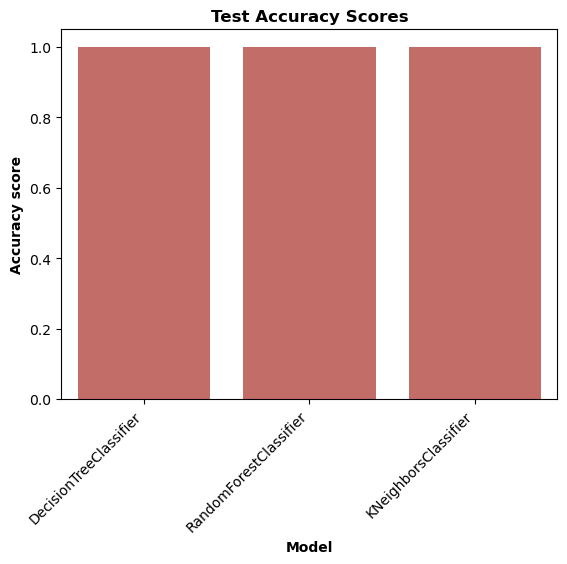

In [29]:
model_accuracies = pd.DataFrame(model_accuracies)
print(model_accuracies)
sns.set_palette("Spectral", n_colors=6, desat=0.8)

score_plot = sns.barplot(data=model_accuracies, y="Accuracy", x="Model")

# rotate the ticks 45 degrees for the sake of redability
score_plot.set_xticklabels(score_plot.get_xticklabels(), rotation=45, horizontalalignment='right')

plt.title("Test Accuracy Scores",
          fontweight="bold")
ax.bar_label(score_plot.containers[0], fontweight="bold")
plt.xlabel("Model", fontweight="bold")
plt.ylabel("Accuracy score", fontweight="bold")

plt.show()